### Figures for my Denver APS poster in 2019 April.

In [1]:
import os, pdb
import numpy as np
import numpy.ma as ma
import pandas as pd
from scipy.stats import binned_statistic
import warnings
from matplotlib.ticker import FormatStrFormatter, MultipleLocator, ScalarFormatter
import matplotlib.pyplot as plt

In [2]:
from astropy.io import fits, ascii
from astropy.table import Table, hstack
from astrometry.libkd.spherematch import match_radec

In [3]:
import colossus.halo
from colossus.cosmology import cosmology
cosmology.setCosmology('planck18')

In [53]:
import legacyhalos.io
import legacyhalos.misc
from legacyhalos.misc import lambda2mhalo, plot_style
sns, colors = plot_style(paper=True)
linestyle = ['-', '--', '-.', ':']
sns.set(font_scale=2, style='ticks')

In [41]:
%matplotlib inline

In [42]:
hdefault = 0.7 # 0.677 # Hubble constant
omega_b = 0.048 # from Knebe+18
omega_m = 0.307

In [43]:
datadir = legacyhalos.io.paper2_dir(data=True)
talkdir = os.path.join(legacyhalos.io.legacyhalos_dir(), 'science', 'talks', 'aps-2019apr')
if not os.path.exists(talkdir):
    os.makedirs(talkdir)
print(talkdir)

/Users/ioannis/research/projects/legacyhalos/science/talks/aps-2019apr


In [44]:
def mstar_label():
    return r'$\log_{10}\, (\mathcal{M}_{*}\ /\ h^{-2}\, \mathcal{M}_{\odot})$'
def mhalo_label():
    return r'$\log_{10}\, (\mathcal{M}_{\rm halo}\, /\, \mathcal{M}_{\odot})$'
def mstar_label2():
    return r'$\log_{10}\, (\mathcal{M}_{*}\ /\ h^{-1}\, \mathcal{M}_{\odot})$'
def mstar_label3():
    return r'$\log_{10}\, (\mathcal{M}_{*}\, /\, \mathcal{M}_{\odot})$'
def phi_label():
    return r'$\log_{10}\, (\Phi\ /\ h^{3}$ Mpc$^{-3}$ dex$^{-1})$'
def phi_label2():
    return r'$\log_{10}\, (\Phi\ /\ {\rm Mpc}^{-3}\ {\rm dex}^{-1})$'
def mstar_mhalo_label():
    return r'$log_{10}\, (\mathcal{M}_{*}\ /\ \mathcal{M}_{\rm halo})\ /\ (\Omega_b\ /\ \Omega_m)$'

## Remake some plots from the literature.

In [83]:
profiles1dmstar = Table.read(os.path.join(datadir, 'paper2-profiles1d-mstar.fits'))
profiles1dmstar.colnames

['MEM_MATCH_ID',
 'RA',
 'DEC',
 'Z',
 'LAMBDA_CHISQ',
 'ID_CENT',
 'RMAX_G',
 'RMAX_R',
 'RMAX_Z',
 'RAD',
 'RAD_AREA',
 'MSTAR10',
 'MSTAR10_ERR',
 'MSTAR30',
 'MSTAR30_ERR',
 'MSTAR100',
 'MSTAR100_ERR',
 'MSTARRMAX',
 'MSTARRMAX_ERR',
 'MSTARRAD',
 'MSTARRAD_ERR',
 'MURAD',
 'MURAD_ERR']

In [94]:
def qa_smhm_obs(aperture='rmax', png=None):
    """Generate figures of the stellar mass vs halo mass and of
    the stellar mass / halo mass vs halo mass relations, including
    data from the literature.
    
    """
    from colossus.halo import mass_defs
    
    # The linear fit from Kravtsov is as a function of M500c; convert it to 
    # M200c here assuming a halo concentration of 3.5.
    #mm, _, _ = mass_defs.changeMassDefinition(10**14.5, 3.5, 0.0, '500c', '200c')
    #offset = np.log10(mm / 10**14.5)
    
    ap2mstar = {'10kpc': 'MSTAR10', '30kpc': 'MSTAR30', '100kpc': 'MSTAR100', 'rmax': 'MSTARRMAX'}
    mstarlabel = ap2mstar[aperture]
    good = np.where(profiles1dmstar[mstarlabel] > 0)[0]
    mstar, mstarerr = profiles1dmstar[mstarlabel][good], profiles1dmstar['{}_ERR'.format(mstarlabel)][good]
        
    lambda_chisq, z = sample['LAMBDA_CHISQ'][good], sample['Z_LAMBDA'][good]
    rich = lambda_chisq > 100
    
    M200c = lambda2mhalo(lambda_chisq, redshift=z)
    stats = legacyhalos.misc.statsinbins(M200c, mstar)
    
    col = iter(colors)
    fig, ax = plt.subplots(figsize=(10, 7))
    
    gonz = legacyhalos.io.literature(gonzalez=True, kravtsov=False)
    krav = legacyhalos.io.literature(kravtsov=True, gonzalez=False)
    
    g = ax.errorbar(gonz['m200c'], gonz['mbcg'], yerr=gonz['mbcg_err'], color=next(col),
                    alpha=0.8, fmt='D', label='Gonzalez+13', markersize=10,
                    capsize=5, elinewidth=2, markeredgewidth=2)
    k = ax.errorbar(krav['m200c'], krav['mbcg'], yerr=krav['mbcg_err'], color=next(col),
                    alpha=0.8, fmt='s', label='Kravtsov+18', markersize=10,
                    capsize=5, elinewidth=2, markeredgewidth=2)
                    
    #r = ax.scatter(mhalo[rich], mstar[rich], alpha=0.9, color=next(col),
    #               edgecolor='k', marker='D', s=50, label='\emph{legacyhalos} ($\lambda>100$)')
    #r = ax.scatter(M200c, mstar, alpha=0.5, color='tan', #next(col),
    #               edgecolor='k', marker='D', s=20, label='Moustakas+19')
    r = ax.errorbar(M200c[rich], mstar[rich], mstarerr[rich], alpha=0.7, color=next(col),
                    fmt='o', markersize=12, label='Moustakas+19 ($\lambda>100$)',
                    capsize=5, elinewidth=2, markeredgewidth=2,
                    markeredgecolor='k')
    #r = ax.scatter(M200c[rich], mstar[rich], alpha=0.9, color=next(col),
    #               edgecolor='k', marker='D', s=30, label='Moustakas+19')
    #r = ax.errorbar(mhalo, mstar, yerr=mstarerr, alpha=0.9, color=next(col),
    #                marker='D', label='\emph{legacyhalos} ($\lambda>100$)')

    #ax.text(0.12, 0.16, '\emph{legacyhalos}\n$z\sim0.2$', multialignment='center',
    #        transform=ax.transAxes, fontsize=18)
    #ax.text(0.12, 0.16, 'redMaPPer\n$0.1<z<0.3$', multialignment='center',
    #        transform=ax.transAxes, fontsize=14)
    
    #m500axis = np.linspace(13, 15.25, 50)
    
    # Relation from Pillepich+18
    p18mhalo = np.linspace(13, 15, 50)
    p18mstar = np.polyval([0.59, 12], p18mhalo-14)+np.log10(0.7)
    pp = ax.fill_between(p18mhalo, p18mstar+0.12, p18mstar-0.12, 
                         color='tan', alpha=0.3, label='Pillepich+18 (TNG)')
    #ff = ax.plot(p18mhalo, p18mstar, ls='-', color='k', 
    #             label='Pillepich+18')
    
    #ff = ax.plot(m500axis, np.polyval([0.33, 12.24], m500axis-14.5)+2*np.log10(0.7), ls='-', 
    #            color='k', label=r'$\mathcal{M}_{BCG}\propto \mathcal{M}_{200c}^{0.33}$')
    #ax.text(0.12, 0.9, r'$\mathcal{M}_{BCG}\propto \mathcal{M}_{200c}^{0.33}$', multialignment='center',
    #        transform=ax.transAxes, fontsize=18)
    #ax.plot([13.55, 13.68], [12.8, 12.8]+2*np.log10(0.7), ls='-', color='k') # hack!!!
    #ax.plot([13.55, 13.68], [12.65, 12.65], ls='-', color='k') # hack!!!
    
    # Overplot the stellar mass-halo mass relation from Behroozi+13:
    b13mhalo, b13mstar_mhalo, b13errlo, b13errup = np.loadtxt(os.path.join(
        os.getenv('CATALOGS_DIR'), '13behroozi',  'smmr', 
        'c_smmr_z0.10_red_all_smf_m1p1s1_bolshoi_fullcosmos_ms.dat'),
                                              unpack=True)
    bb = ax.fill_between(b13mhalo, b13mstar_mhalo+b13mhalo+b13errup, 
                         b13mstar_mhalo+b13mhalo-b13errlo, alpha=0.4,
                         color='gray', label='Behroozi+13 (SHAM)')
    #ax.plot(b13mhalo, b13mstar_mhalo+b13mhalo, ls='-', color='k')
    #ax.text(0.11, 0.31, 'Behroozi+13', multialignment='center',
    #        transform=ax.transAxes, fontsize=14)
    
    ax.plot(stats['xmedian'], stats['ymedian'], color='k', ls='-', lw=3)#, alpha=0.5)
    ax.plot(stats['xmedian'], stats['y75'], color='k', ls='--', lw=3)#, alpha=0.5)
    ax.plot(stats['xmedian'], stats['y25'], color='k', ls='--', lw=3)#, alpha=0.5)
 
    #mh = np.log10(lambda2mhalo(cat2['lambda_chisq'], redshift=cat2['z_1']))
    #ms = cat2['mstar_avg']
    #ax.scatter(mh, ms, s=10, color='orange', alpha=0.2)

    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

    hh = [g, k, r, bb, pp]
    ax.legend(hh, [H.get_label() for H in hh], loc='lower right',
              frameon=True, fontsize=14, ncol=1)
    #ax.legend(ff, ff.get_label(), loc='upper left',
    #          frameon=True, fontsize=16)
    #ax.legend(loc='upper left', frameon=True, fontsize=16)

    ax.set_ylim(10.5, 12.6)
    #ax.set_ylim(10.5, 13)
    ax.set_xlim(13.5, 15.05)

    ax.set_xlabel(r'$\log_{10}\, (\mathcal{M}_{200c}\ /\ \mathcal{M}_{\odot})$')
    ax.set_ylabel(r'$\log_{10}\, (\mathcal{M}_{central, r<100\,kpc}\ /\ \mathcal{M}_{\odot})$')
    
    plt.subplots_adjust(left=0.18, bottom=0.15, top=0.95, right=0.95)
    
    if png:
        plt.savefig(os.path.join(talkdir, png))

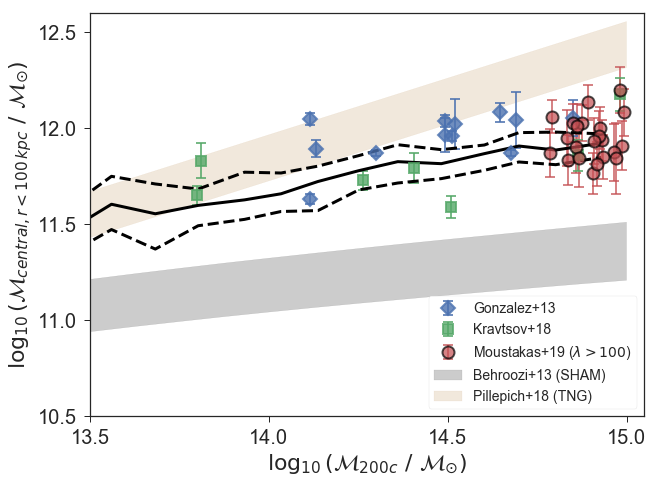

In [95]:
qa_smhm_obs(aperture='100kpc', png='mbcg-m200c-100kpc.png')

In [79]:
def qa_smhm_relation(png=None):
    """Data taken from Behroozi+13."""
    mhalo, mstar_mhalo, errlo, errup = np.loadtxt(os.path.join(
        os.getenv('CATALOGS_DIR'), '13behroozi',  'smmr', 
        'c_smmr_z0.10_red_all_smf_m1p1s1_bolshoi_fullcosmos_ms.dat'),
                                              unpack=True)
    keep = (mhalo > 10) * (mhalo < 15)
    mstar_mhalo = mstar_mhalo[keep]
    mhalo = mhalo[keep]
    errlo = errlo[keep]
    errup = errup[keep]
    
    sfe = 10**(mstar_mhalo + np.log10(omega_m / omega_b))
    sfe_up = 10**(mstar_mhalo + errup + np.log10(omega_m / omega_b))
    sfe_lo = 10**(mstar_mhalo - errlo + np.log10(omega_m / omega_b))
    keep = sfe > 0.001

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.fill_between(mhalo[keep], sfe_lo[keep], sfe_up[keep], alpha=0.9)
    #ax.plot(mhalo, sfe)
    ax.grid()
    ax.set_xlim(10, 15)
    ax.set_ylim(0.001, 0.6)
    ax.set_yscale('log')
    
    ax.set_yticks([0.001, 0.003, 0.01, 0.03, 0.1, 0.3])
    ax.get_yaxis().set_major_formatter(ScalarFormatter())

    ax.set_xlabel(mhalo_label())
    ax.set_ylabel(mstar_mhalo_label())
    
    #ax.text(11.2, 0.006, 'Central Galaxies', va='center', 
    #        ha='left', fontsize=20, style='italic')
    
    if png:
        plt.savefig(os.path.join(talkdir, png))

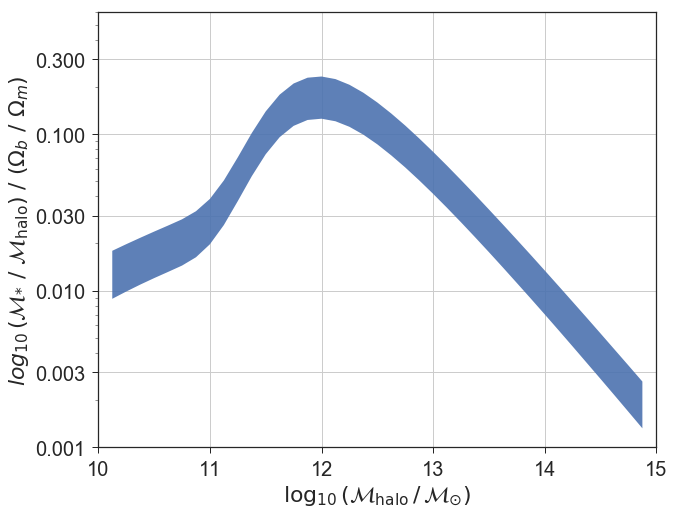

In [80]:
qa_smhm_relation(png='toy-smhm.png')

### Read the catalogs we need.

In [18]:
sample = legacyhalos.io.read_paper2_sample()
#lsphot = legacyhalos.io.read_paper2_sample(isedfit_lsphot=True, verbose=True)
#sdssphot = legacyhalos.io.read_paper2_sample(isedfit_sdssphot=True, verbose=True)

#### Montage of 100 random clusters.

In [19]:
M200c = lambda2mhalo(sample['LAMBDA_CHISQ'].data, redshift=sample['Z_LAMBDA'].data)

In [31]:
def make_montage(infiles):
    montagefile = os.path.join(talkdir, 'centrals-gallery.png')

    ncol = 7
    nrow = 4
    
    cmd = 'montage -bordercolor white -borderwidth 1 -tile {}x{} -geometry 512x512 '.format(ncol, nrow)
    cmd = cmd+' '.join([inff for inff in infiles])
    cmd = cmd+' {}'.format(montagefile)
    #print(cmd)
    os.system(cmd)        
    print('Writing {}'.format(montagefile))

In [36]:
galaxy, galaxydir = legacyhalos.io.get_galaxy_galaxydir(sample)
rand = np.random.RandomState(seed=11)
these = rand.choice(len(galaxy), 28, replace=False)
srt = np.argsort(M200c[these])
indx = these[srt]
#indx[23] = indx[23]+1
#indx[6] = indx[6]+1
#indx[27] = indx[27]+1
#indx[28] = indx[28]+1
print(M200c[indx])
infiles = [os.path.join(galdir, '{}-custom-image-grz.jpg'.format(gal)) for gal, galdir in zip(galaxy[indx], galaxydir[indx])]
#M200c[these[srt]]

[13.419211  13.433597  13.501052  13.527776  13.530762  13.549618
 13.683224  13.811035  13.84355   13.895906  13.94577   13.98644
 13.9895115 13.994646  14.067983  14.10101   14.119151  14.129429
 14.13162   14.14132   14.1462145 14.163409  14.236219  14.249949
 14.324243  14.3921995 14.782734  14.9183   ]


In [37]:
if True:
    make_montage(infiles)

Writing /Users/ioannis/research/projects/legacyhalos/science/talks/aps-2019apr/centrals-gallery.png


In [263]:
profiles1dmstar = Table.read(os.path.join(datadir, 'paper2-profiles1d-mstar.fits'))
profiles1dmstar.colnames

['MEM_MATCH_ID',
 'RA',
 'DEC',
 'Z',
 'LAMBDA_CHISQ',
 'ID_CENT',
 'RMAX_G',
 'RMAX_R',
 'RMAX_Z',
 'RAD',
 'RAD_AREA',
 'MSTAR10',
 'MSTAR10_ERR',
 'MSTAR30',
 'MSTAR30_ERR',
 'MSTAR100',
 'MSTAR100_ERR',
 'MSTARRMAX',
 'MSTARRMAX_ERR',
 'MSTARRAD',
 'MSTARRAD_ERR',
 'MURAD',
 'MURAD_ERR']

## Stellar mass density profiles in different bins of stellar mass / halo mass.

In [264]:
M200c = lambda2mhalo(sample['LAMBDA_CHISQ'], redshift=sample['Z_LAMBDA'])

In [265]:
dmhalo = 0.5
mhalomin = np.arange(13.5, 15, dmhalo)
mhalomax = mhalomin + dmhalo

In [329]:
#dmstar = 0.5
#mstarmin = np.arange(11.0, 13, dmstar)
#mstarmax = mstarmin + dmstar
#mstarmin = [11, 11.5, 11.75, 12]
#mstarmax = [11.5, 11.75, 12, 12.5]
mstarmin = [11.0, 11.4, 11.8]
mstarmax = [11.4, 11.8, 12.2]
print(mstarmin, mstarmax)

[11.0, 11.4, 11.8] [11.4, 11.8, 12.2]


In [330]:
def mean_mstarprofile(mhalo, mhalomin=14, mhalomax=15, R200norm=True):
    """Mean cumulative stellar mass profiles."""
    ww = np.where((mhalo > mhalomin) * (mhalo < mhalomax))[0]
    
    if R200norm:
        medmhalo, medz = np.median(mhalo[ww]), 0.3 # np.median(profiles1dmstar['Z'][ww])
        rnorm = colossus.halo.mass_so.M_to_R(10**medmhalo, medz, '200c') # use Z_LAMBDA here!
    else:
        rnorm = 1.0

    radfrac, mstarfrac = [], []
    for pp in profiles1dmstar[ww]:
        if pp['MSTAR100'] > 0:
            good = pp['MSTARRAD'] > 0
            mstarsum = np.log10(np.cumsum(10**pp['MSTARRAD'][good]))
            #if R200norm:
            #    rnorm = colossus.halo.mass_so.M_to_R(10**mhalo[ww[ii]], pp['Z'], '200c') # use Z_LAMBDA here!
            #else:
            #    rnorm = 1.0
            radfrac.append(np.log10(pp['RAD'][good] / rnorm)) # normalize by R200!
            mstarfrac.append(mstarsum)
            #mstarfrac.append(10**(mstarsum-mstarsum[-1]))

    stats = legacyhalos.misc.statsinbins(np.hstack(radfrac), np.hstack(mstarfrac), binsize=0.1)
    return stats, radfrac, mstarfrac

In [331]:
def mean_muprofile_mhalo(mhalo, mhalomin=14, mhalomax=15):
    """Mean stellar mass density profiles in bins of halo mass."""
    ww = np.where((mhalo > mhalomin) * (mhalo < mhalomax))[0]
    
    radfrac, mstarfrac = [], []
    for pp in profiles1dmstar[ww]:
        if pp['MSTAR100'] > 0:
            good = pp['MURAD'] > 0
            mstarsum = pp['MURAD'][good]

            radfrac.append(pp['RAD'][good]**0.25)
            mstarfrac.append(mstarsum)

    stats = legacyhalos.misc.statsinbins(np.hstack(radfrac), np.hstack(mstarfrac), binsize=0.1)
    return stats, radfrac, mstarfrac

In [332]:
def mean_muprofile_mstar(mstar, mstarmin=10.5, mstarmax=12.5):
    """Mean stellar mass density profiles in bins of stellar mass."""
    ww = np.where((mstar > mstarmin) * (mstar < mstarmax))[0]
    radfrac, mstarfrac = [], []
    for pp in profiles1dmstar[ww]:
        if pp['MSTAR100'] > 0:
            good = pp['MURAD'] > 0
            mstarsum = pp['MURAD'][good]

            radfrac.append(pp['RAD'][good]**0.25)
            mstarfrac.append(mstarsum)

    stats = legacyhalos.misc.statsinbins(np.hstack(radfrac), np.hstack(mstarfrac), binsize=0.1)
    #import pdb ; pdb.set_trace()
    return stats, radfrac, mstarfrac

In [341]:
def qa_muprofile_mstar(png=None):

    good = profiles1dmstar['MSTAR100'] > 0
    goodmstar = profiles1dmstar['MSTAR100'][good]
    
    fig, ax = plt.subplots(figsize=(10, 7))
    for ii, (hmin, hmax) in enumerate(zip(mstarmin, mstarmax)):
        stats, radfrac, mstarfrac = mean_muprofile_mstar(goodmstar, hmin, hmax)
        ax.plot(stats['xbin'], stats['ymean'], lw=4, color=colors[ii], 
                ls=linestyle[ii], 
                label=r'${:.1f}<\log_{{10}}\,(\mathcal{{M}}_{{*,r<100\,kpc}}/\mathcal{{M}}_\odot)<{:.1f}$'.format(hmin, hmax))
        for rr, mm in zip(radfrac, mstarfrac):
            ax.plot(rr, mm, lw=1, alpha=0.05, color=colors[ii])
            
    ax.legend(loc='upper right', fontsize=18)
    ax.set_ylabel(r'$\log_{{10}}\,[\mu_{{*}}\ /\ (\mathcal{{M}}_{\odot}\ kpc^{-2}$)]')
    #ax.set_ylim(0, 1.02)
    ax.set_ylim(5, 10.5)
    ax.set_xlim(0.8, 3.3)
    
    ylim = ax.get_ylim()
    ax.fill_between([0, 0.9], [ylim[1], ylim[1]], [ylim[0], ylim[0]], 
                    color='grey', alpha=0.3)
    ax.text(0.025, 0.1, 'PSF', ha='center', va='center', rotation=90,
            transform=ax.transAxes, fontsize=14)

    ax.set_xlabel(r'$(r\ /\ kpc)^{1/4}$')
    
    ax2 = ax.twiny()
    xlim = ax.get_xlim()
    ax2.set_xlim((xlim[0]**4, xlim[1]**4))
    ax2.set_xlabel(r'$r\ /\ kpc$')
    ax2.set_xticks((10, 30, 50, 70, 100, 120, 140))
        
    if png:
        plt.savefig(os.path.join(talkdir, png))            

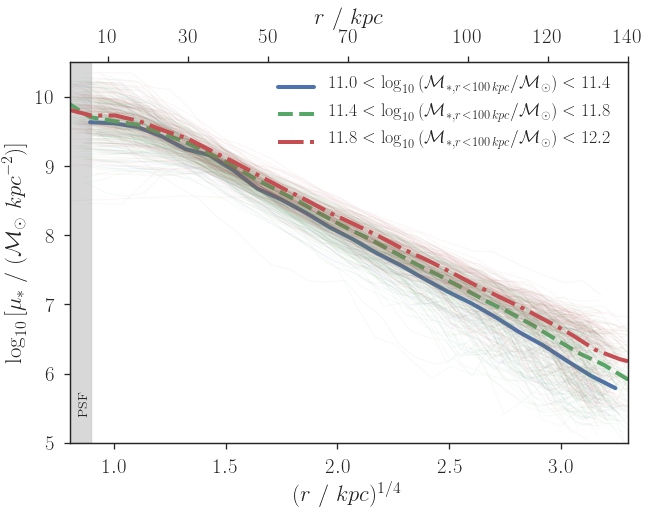

In [342]:
qa_muprofile_mstar(png='mustar-radius-mstar.png')

In [343]:
def qa_muprofile_mhalo(png=None):

    fig, ax = plt.subplots(figsize=(10, 7))
    for ii, (hmin, hmax) in enumerate(zip(mhalomin, mhalomax)):
        stats, radfrac, mstarfrac = mean_muprofile_mhalo(M200c, hmin, hmax)
        ax.plot(stats['xbin'], stats['ymean'], lw=4, color=colors[ii], 
                ls=linestyle[ii], 
                label=r'${:.1f}<\log_{{10}}\,(\mathcal{{M}}_{{200c}}/\mathcal{{M}}_\odot)<{:.1f}$'.format(hmin, hmax))
        for rr, mm in zip(radfrac, mstarfrac):
            ax.plot(rr, mm, lw=1, alpha=0.05, color=colors[ii])
            
    ax.legend(loc='upper right', fontsize=18)
    ax.set_ylabel(r'$\log_{{10}}\,[\mu_{{*}}\ /\ (\mathcal{{M}}_{\odot}\ kpc^{-2}$)]')
    #ax.set_ylim(0, 1.02)
    ax.set_ylim(5, 10.5)
    ax.set_xlim(0.8, 3.3)
    
    ylim = ax.get_ylim()
    ax.fill_between([0, 0.9], [ylim[1], ylim[1]], [ylim[0], ylim[0]], 
                    color='grey', alpha=0.3)
    ax.text(0.025, 0.1, 'PSF', ha='center', va='center', rotation=90,
            transform=ax.transAxes, fontsize=14)

    ax.set_xlabel(r'$(r\ /\ kpc)^{1/4}$')
    
    ax2 = ax.twiny()
    xlim = ax.get_xlim()
    ax2.set_xlim((xlim[0]**4, xlim[1]**4))
    ax2.set_xlabel(r'$r\ /\ kpc$')
    ax2.set_xticks((10, 30, 50, 70, 100, 120, 140))
        
    if png:
        plt.savefig(os.path.join(talkdir, png))            

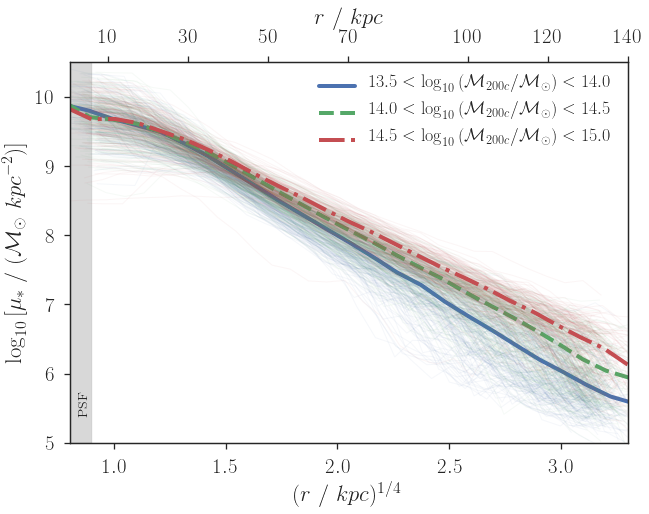

In [344]:
qa_muprofile_mhalo(png='mustar-radius-mhalo.png')

In [ ]:
def qa_mstarprofile():
    fig, ax = plt.subplots(figsize=(8, 6))
    for ii, (hmin, hmax) in enumerate(zip(mhalomin, mhalomax)):
        stats, radfrac, mstarfrac = mean_mstarprofile(M200c, hmin, hmax, R200norm=False)
        ax.plot(stats['xmean'], stats['ymean'], lw=4, color=colors[ii], 
                label=r'${:.1f}<\log\,(M_h/M_\odot)<{:.1f}$'.format(hmin, hmax))
        for rr, mm in zip(radfrac, mstarfrac):
            ax.plot(rr, mm, lw=1, alpha=0.03, color=colors[ii])
        
    ax.legend(loc='upper left', fontsize=14)
    ax.set_ylabel(r'$\log_{10}\,(M_{BCG}\ /\ M_{\odot})$')
    #ax.set_ylim(0, 1.02)
    ax.set_ylim(10, 12.2)

    if False:
        ax.set_xlim(-3.5, -0.05)
        ax.set_xlabel(r'$\log_{10}\,(R\ /\ R_{200c})$')
    else:
        ax.set_xlim(-0.5, 2.2)
        ax.set_xlabel(r'$\log_{10}\,(R\ /\ kpc)$')   

In [ ]:
stop

## Stellar mass-halo mass relation

In [270]:
def qa_smhm_obs(aperture='rmax', png=None):
    """Generate figures of the stellar mass vs halo mass and of
    the stellar mass / halo mass vs halo mass relations, including
    data from the literature.
    
    """
    from colossus.halo import mass_defs
    
    # The linear fit from Kravtsov is as a function of M500c; convert it to 
    # M200c here assuming a halo concentration of 3.5.
    #mm, _, _ = mass_defs.changeMassDefinition(10**14.5, 3.5, 0.0, '500c', '200c')
    #offset = np.log10(mm / 10**14.5)
    
    ap2mstar = {'10kpc': 'MSTAR10', '30kpc': 'MSTAR30', '100kpc': 'MSTAR100', 'rmax': 'MSTARRMAX'}
    mstarlabel = ap2mstar[aperture]
    good = np.where(profiles1dmstar[mstarlabel] > 0)[0]
    mstar, mstarerr = profiles1dmstar[mstarlabel][good], profiles1dmstar['{}_ERR'.format(mstarlabel)][good]
        
    lambda_chisq, z = sample['LAMBDA_CHISQ'][good], sample['Z_LAMBDA'][good]
    rich = lambda_chisq > 100
    
    M200c = lambda2mhalo(lambda_chisq, redshift=z)
    stats = legacyhalos.misc.statsinbins(M200c, mstar)
    
    col = iter(colors)
    fig, ax = plt.subplots(figsize=(10, 7))
    
    gonz = legacyhalos.io.literature(gonzalez=True, kravtsov=False)
    krav = legacyhalos.io.literature(kravtsov=True, gonzalez=False)
    
    g = ax.errorbar(gonz['m200c'], gonz['mbcg'], yerr=gonz['mbcg_err'], color=next(col),
                    alpha=0.8, fmt='D', label='Gonzalez+13', markersize=10,
                    capsize=5, elinewidth=2, markeredgewidth=2)
    k = ax.errorbar(krav['m200c'], krav['mbcg'], yerr=krav['mbcg_err'], color=next(col),
                    alpha=0.8, fmt='s', label='Kravtsov+18', markersize=10,
                    capsize=5, elinewidth=2, markeredgewidth=2)
                    
    #r = ax.scatter(mhalo[rich], mstar[rich], alpha=0.9, color=next(col),
    #               edgecolor='k', marker='D', s=50, label='\emph{legacyhalos} ($\lambda>100$)')
    #r = ax.scatter(M200c, mstar, alpha=0.5, color='tan', #next(col),
    #               edgecolor='k', marker='D', s=20, label='Moustakas+19')
    r = ax.errorbar(M200c[rich], mstar[rich], mstarerr[rich], alpha=0.7, color=next(col),
                    fmt='o', markersize=12, label='Moustakas+19 ($\lambda>100$)',
                    capsize=5, elinewidth=2, markeredgewidth=2,
                    markeredgecolor='k')
    #r = ax.scatter(M200c[rich], mstar[rich], alpha=0.9, color=next(col),
    #               edgecolor='k', marker='D', s=30, label='Moustakas+19')
    #r = ax.errorbar(mhalo, mstar, yerr=mstarerr, alpha=0.9, color=next(col),
    #                marker='D', label='\emph{legacyhalos} ($\lambda>100$)')

    #ax.text(0.12, 0.16, '\emph{legacyhalos}\n$z\sim0.2$', multialignment='center',
    #        transform=ax.transAxes, fontsize=18)
    #ax.text(0.12, 0.16, 'redMaPPer\n$0.1<z<0.3$', multialignment='center',
    #        transform=ax.transAxes, fontsize=14)
    
    #m500axis = np.linspace(13, 15.25, 50)
    
    # Relation from Pillepich+18
    p18mhalo = np.linspace(13, 15, 50)
    p18mstar = np.polyval([0.59, 12], p18mhalo-14)+np.log10(0.7)
    pp = ax.fill_between(p18mhalo, p18mstar+0.12, p18mstar-0.12, 
                         color='tan', alpha=0.3, label='Pillepich+18 (TNG)')
    #ff = ax.plot(p18mhalo, p18mstar, ls='-', color='k', 
    #             label='Pillepich+18')
    
    #ff = ax.plot(m500axis, np.polyval([0.33, 12.24], m500axis-14.5)+2*np.log10(0.7), ls='-', 
    #            color='k', label=r'$\mathcal{M}_{BCG}\propto \mathcal{M}_{200c}^{0.33}$')
    #ax.text(0.12, 0.9, r'$\mathcal{M}_{BCG}\propto \mathcal{M}_{200c}^{0.33}$', multialignment='center',
    #        transform=ax.transAxes, fontsize=18)
    #ax.plot([13.55, 13.68], [12.8, 12.8]+2*np.log10(0.7), ls='-', color='k') # hack!!!
    #ax.plot([13.55, 13.68], [12.65, 12.65], ls='-', color='k') # hack!!!
    
    # Overplot the stellar mass-halo mass relation from Behroozi+13:
    b13mhalo, b13mstar_mhalo, b13errlo, b13errup = np.loadtxt(os.path.join(
        os.getenv('CATALOGS_DIR'), '13behroozi',  'smmr', 
        'c_smmr_z0.10_red_all_smf_m1p1s1_bolshoi_fullcosmos_ms.dat'),
                                              unpack=True)
    bb = ax.fill_between(b13mhalo, b13mstar_mhalo+b13mhalo+b13errup, 
                         b13mstar_mhalo+b13mhalo-b13errlo, alpha=0.4,
                         color='gray', label='Behroozi+13 (SHAM)')
    #ax.plot(b13mhalo, b13mstar_mhalo+b13mhalo, ls='-', color='k')
    #ax.text(0.11, 0.31, 'Behroozi+13', multialignment='center',
    #        transform=ax.transAxes, fontsize=14)
    
    ax.plot(stats['xmedian'], stats['ymedian'], color='k', ls='-', lw=3)#, alpha=0.5)
    ax.plot(stats['xmedian'], stats['y75'], color='k', ls='--', lw=3)#, alpha=0.5)
    ax.plot(stats['xmedian'], stats['y25'], color='k', ls='--', lw=3)#, alpha=0.5)
 
    #mh = np.log10(lambda2mhalo(cat2['lambda_chisq'], redshift=cat2['z_1']))
    #ms = cat2['mstar_avg']
    #ax.scatter(mh, ms, s=10, color='orange', alpha=0.2)

    #ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.xaxis.set_major_locator(MultipleLocator(0.5))
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

    hh = [g, k, r, bb, pp]
    ax.legend(hh, [H.get_label() for H in hh], loc='lower right',
              frameon=True, fontsize=14, ncol=1)
    #ax.legend(ff, ff.get_label(), loc='upper left',
    #          frameon=True, fontsize=16)
    #ax.legend(loc='upper left', frameon=True, fontsize=16)

    ax.set_ylim(10.5, 12.5)
    #ax.set_ylim(10.5, 13)
    ax.set_xlim(13.5, 15.2)

    ax.set_xlabel(r'$\log_{10}\, (\mathcal{M}_{200c}\ /\ \mathcal{M}_{\odot})$')
    ax.set_ylabel(r'$\log_{10}\, (\mathcal{M}_{BCG, r<100\,kpc}\ /\ \mathcal{M}_{\odot})$')
    
    plt.subplots_adjust(left=0.18, bottom=0.15, top=0.95, right=0.95)
    
    if png:
        plt.savefig(os.path.join(talkdir, png))    

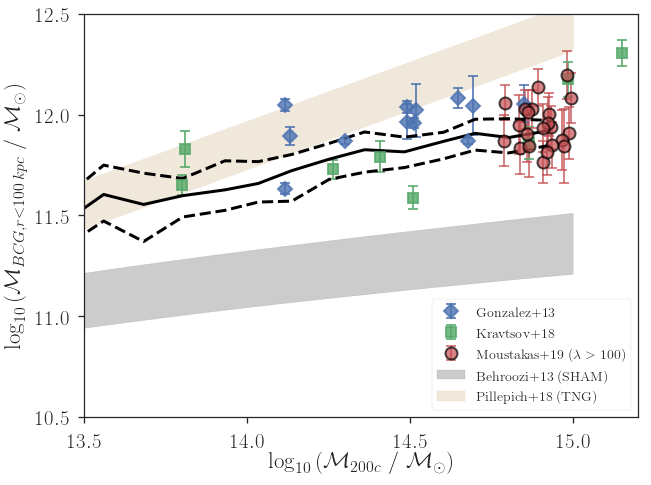

In [271]:
qa_smhm_obs(aperture='100kpc', png='mbcg-m200c-100kpc.png')

In [ ]:
qa_smhm_obs(aperture='rmax', png='mbcg-m200c-rmax.png')

(-0.5, 1)

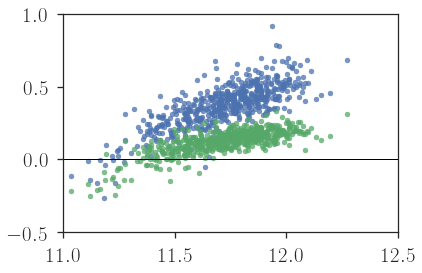

In [74]:
fig, ax = plt.subplots()
ax.scatter(profiles1dmstar['MSTAR100'], profiles1dmstar['MSTAR100']-profiles1dmstar['MSTAR10'], s=25, alpha=0.75)
ax.scatter(profiles1dmstar['MSTAR100'], profiles1dmstar['MSTAR100']-profiles1dmstar['MSTAR30'], s=25, alpha=0.75)
ax.axhline(y=0, color='k', lw=1, ls='-')
ax.set_xlim((11, 12.5))
ax.set_ylim(-0.5, 1)

(0, 1)

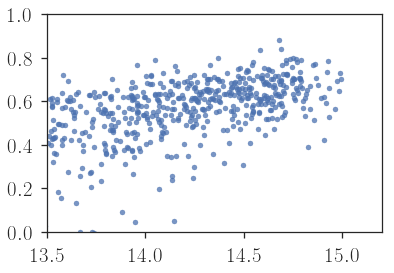

In [80]:
fig, ax = plt.subplots()
#ax.scatter(M200c, 10**(profiles1dmstar['MSTAR100']-profiles1dmstar['MSTAR10']), s=25, alpha=0.75)
ax.scatter(M200c, (10**profiles1dmstar['MSTAR100']-10**profiles1dmstar['MSTAR10'])/10**profiles1dmstar['MSTAR100'], s=25, alpha=0.75)
ax.axhline(y=0, color='k', lw=1, ls='-')
ax.set_xlim(13.5, 15.2)
ax.set_ylim(0, 1)

In [ ]:
pp = profiles1dmstar[1]
print(pp['MSTARRMAX'])
np.log10(np.cumsum(10**pp['MSTARRAD']))

In [ ]:
def mstar_label():
    return r'$\log_{10}\, (\mathcal{M}_{*}\ /\ h^{-2}\, \mathcal{M}_{\odot})$'
def mhalo_label():
    return r'$\log_{10}\, (\mathcal{M}_{\rm halo}\, /\, \mathcal{M}_{\odot})$'
def mstar_label2():
    return r'$\log_{10}\, (\mathcal{M}_{*}\ /\ h^{-1}\, \mathcal{M}_{\odot})$'
def mstar_label3():
    return r'$\log_{10}\, (\mathcal{M}_{*}\, /\, \mathcal{M}_{\odot})$'
def phi_label():
    return r'$\log_{10}\, (\Phi\ /\ h^{3}$ Mpc$^{-3}$ dex$^{-1})$'
def phi_label2():
    return r'$\log_{10}\, (\Phi\ /\ {\rm Mpc}^{-3}\ {\rm dex}^{-1})$'
def mstar_mhalo_label():
    return r'$log_{10}\, (\mathcal{M}_{*}\ /\ \mathcal{M}_{\rm halo})\ /\ (\Omega_b\ /\ \Omega_m)$'